# 13. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다.   
이제 실제 주식값 예측에 도전해 봅시다.   
데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 아래 그림을 따라 하시면 다운로드할 수 있습니다.

**루부릭**  

|평가문항|상세기준|  
|:-------|:-------|  
|1. 시계열의 안정성이 충분히 확인되었는가? | 플로팅과 adfuller 메소드가 모두 적절히 사용되었음|  
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? | p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|   
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? | 3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨|  

## STEP 1 : 시계열 데이터 준비

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 **시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)** 이 저장되어 있는 것을 확인할 수 있지만, 우리는 **Close만 사용**하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [2]:
# Close만 사용
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

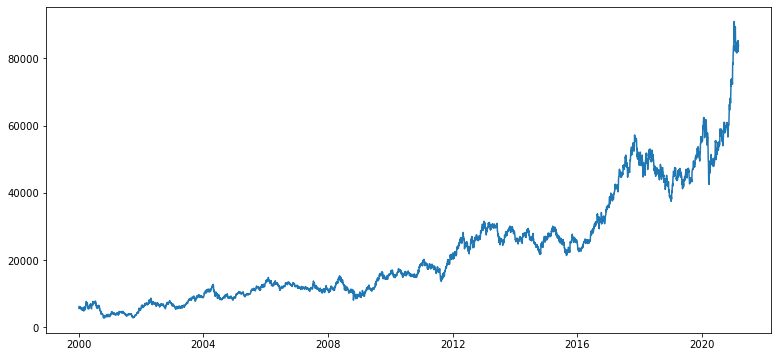

In [3]:
# 시계열 데이터를 차트로 그려보기
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

## STEP 2 : 각종 전처리 수행

* 결측치 처리
* 로그 변환

In [4]:
# 결측치 유무 확인
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [5]:
# 결측치가 있다면 보간하며, 보간 기준은 time, 즉 index인 Date
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

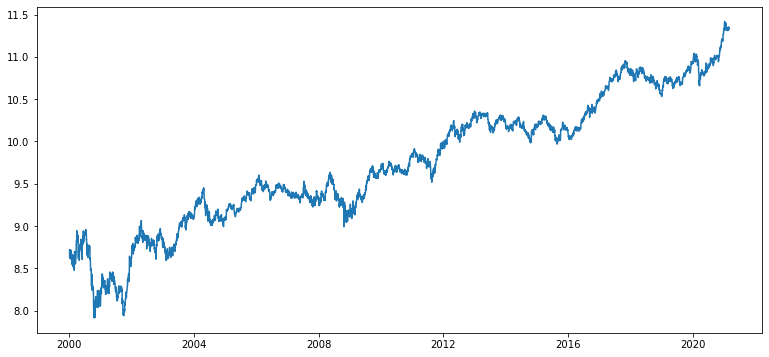

In [6]:
# 로그함수로 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [7]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [8]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


정성적 그래프 분석 :


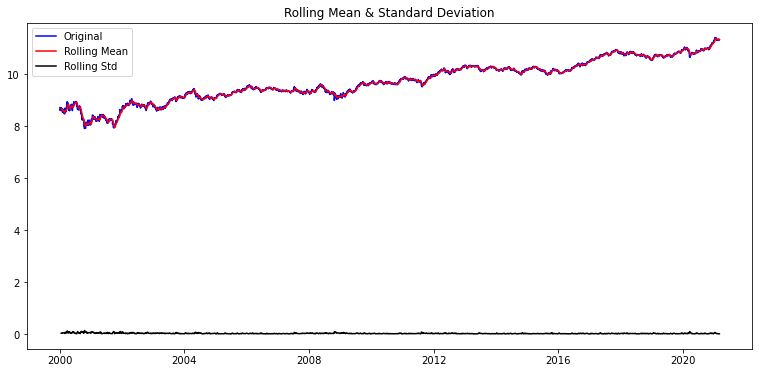


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64

시계열 분해 (Time Series Decomposition) :


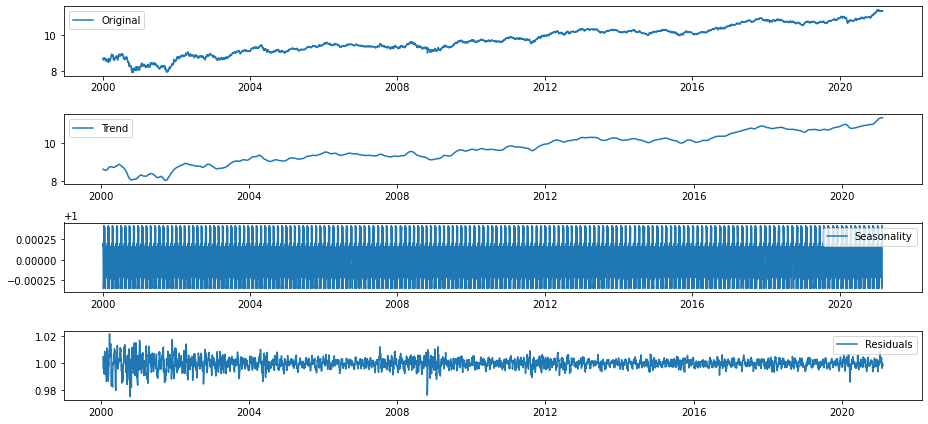

In [9]:
print()
print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

print()
print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

print()
print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

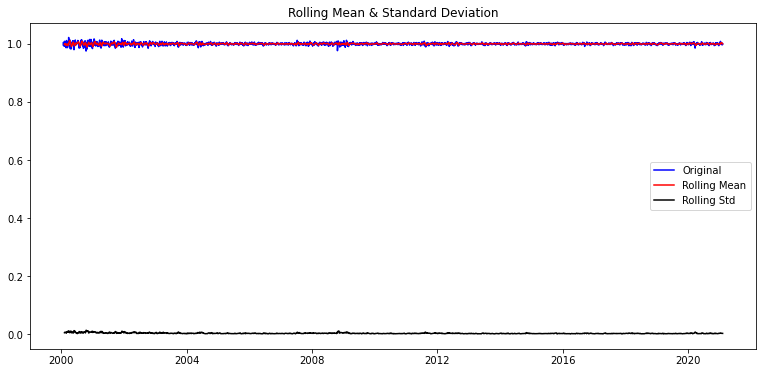

In [10]:
# 정성으로 residual 안정성 확인
plot_rolling_statistics(residual)

In [11]:
# 정량적으로 residual 안정성 분석
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 **낮은 p-value**를 보여 줍니다.   
이 정도면 확실히 예측 가능한 수준의 **안정적인 시계열**이 얻어졌다고 볼 수 있겠습니다

## STEP 4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

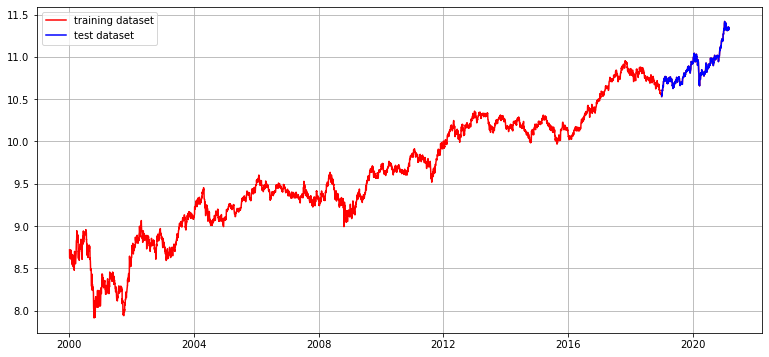

In [12]:
# 학습과 테스트 데이터셋을 9:1로 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
* ARIMA(Autoregressive Integrated Moving Average): 시계열 데이터 예측모델을 자동으로 만들어 주는 모델
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

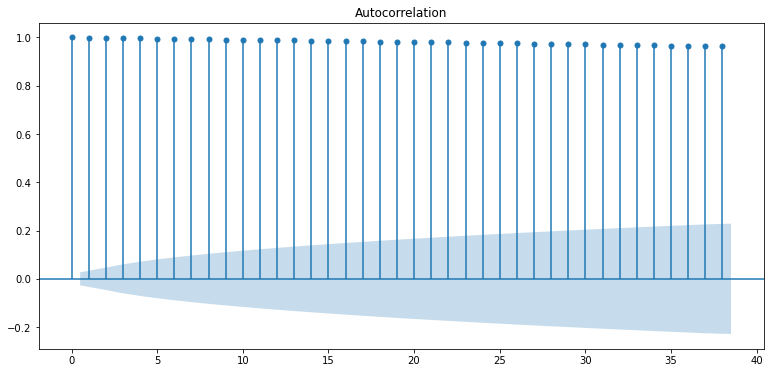

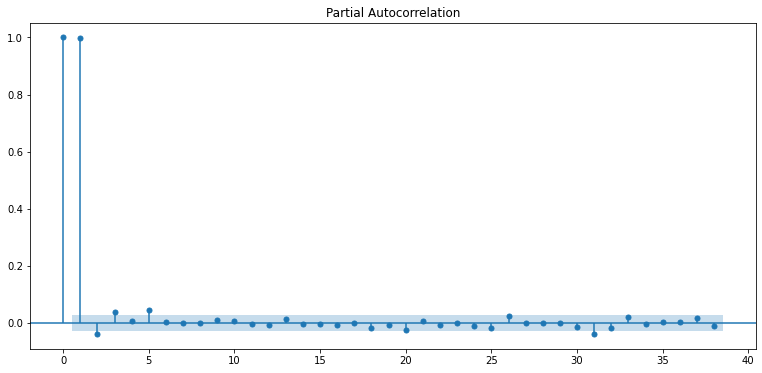

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF 그래프는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다
  - 시차 q 이후에 0에 가까워지는 현상이 없기 때문에 적합한 q 값은 없어 보입니다.
  - MA를 고려할 필요가 없음
  
  
* PACF 그래프는 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 p=1이 매우 적합한 것 같습니다.
  - PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0
  - 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -21.841431
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


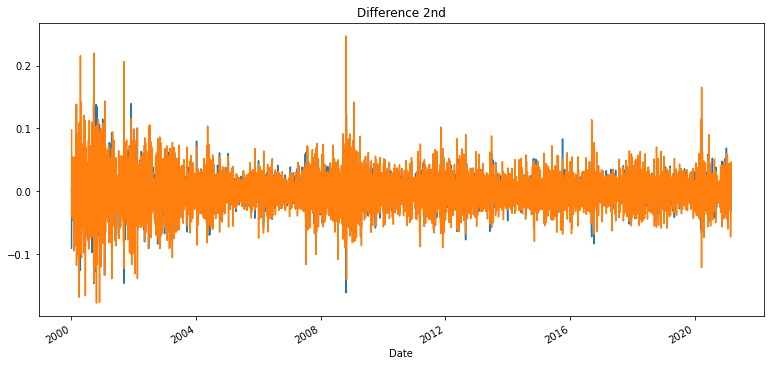

In [14]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
print('\033[31m'+'\033[1m' + "1차 차분 구하기 :" + '\033[0m')
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

print()
print('\033[31m'+'\033[1m' + "2차 차분 구하기 :" + '\033[0m')
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

* ARIMA(p,q,d)의 모수는 3가지가 있는데,
  - 자기회귀 모형(AR)의 시차를 의미하는 p
  - 차분(diffdrence) 횟수를 의미하는 d
  - 이동평균 모형(MA)의 시차를 의미하는 q
  
  - d=0이면, ARMA(p,q)모형이라 부르고 이 모형은 정상성을 만족한다.
  - p=0이면, IMA(d,q)모형이라 부르고 d번 차분하면 MA(q)모형을 따르게 된다.
  - q=0이면, ARI(p,d)모형이라 부르며, d번 차분한 시계열이 AR(p)모형을 따르게 된다.

In [15]:
# ARIMA 모델 훈련
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model (p, d, q)
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  

# 최종 예측 모델 정확도 측정(MAPE)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11282.237
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22558.473
Time:                        20:30:01   BIC                         -22539.052
Sample:                             1   HQIC                        -22551.651
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.093      0.275      -0.000       0.001
ar.L1.D.Close     0.0436      0.014      3.017      0.003       0.015       0.072
                                    Root

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

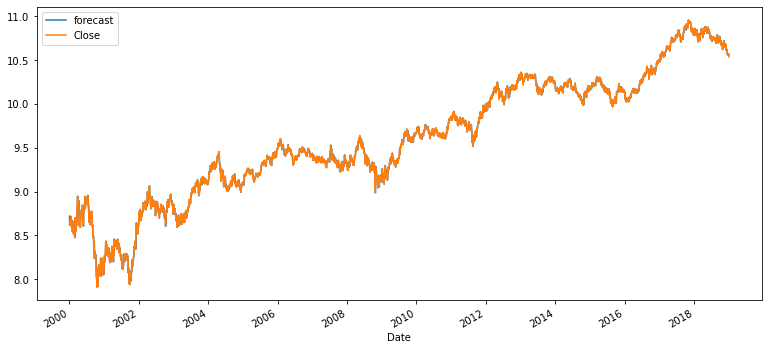

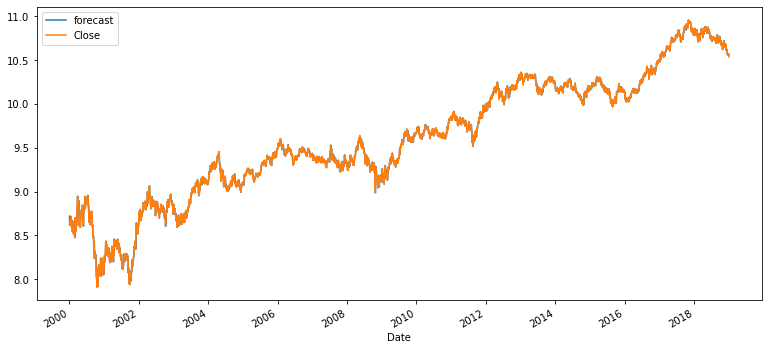

In [16]:
# 훈련데이터에 대해 ARIMA 모델이 잘 fit하는지 시각적으로 확인
fitted_m.plot_predict()

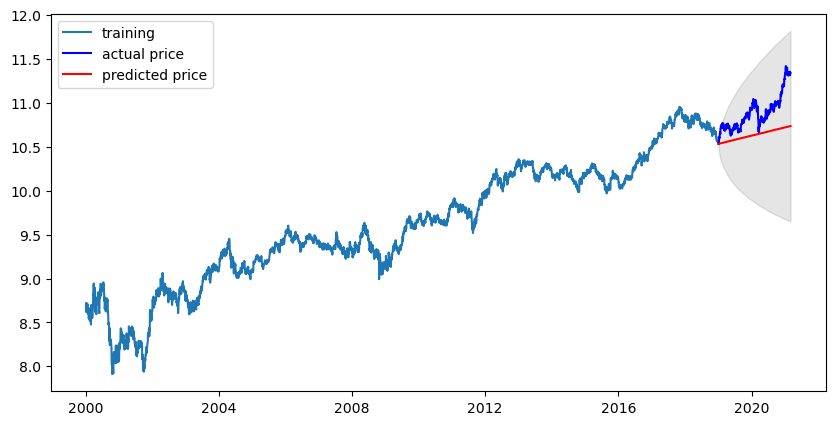

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
# 모델의 오차율 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('\033[31m'+'\033[1m' + 'MSE: ' + '\033[0m', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('\033[31m'+'\033[1m' + 'MAE: ' + '\033[0m', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('\033[31m'+'\033[1m' + 'RMSE: ' + '\033[0m', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('\033[31m'+'\033[1m' + 'MAPE: ' + '\033[0m'+ '{:.2f}%'.format(mape*100))

MSE:  255620975.71648255
MAE:  12827.418269711668
RMSE:  15988.151103754384
MAPE: 21.45%


## STEP 7 : 다른 주식 종목 예측해 보기

* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### Step 7-1. 모듈 불러오기

In [19]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



### Step 7-2. plot_rolling_statistics() 구현

In [20]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### Step 7-3. augmented_dickey_fuller_test() 구현

In [21]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [22]:
# matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 6    

### Step 7-4. stock_stationarity() 구현

In [23]:
def stock_stationarity(stock_id,  period = 30):
    # Time Series 생성
    dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/'+ stock_id
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

    # Close만 사용
    ts = df['Close']

    # 결측치 처리
    ts = ts.interpolate(method='time')

    # 로그 변환
    ts_log = np.log(ts)
    print('\033[31m'+'\033[1m' + "로그 변환된 그래프 :" + '\033[0m') 
    plt.plot(ts_log)
    plt.show()

    # 정성적 그래프 분석
    print()
    print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')    
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    print()
    print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')    
    augmented_dickey_fuller_test(ts_log)
    
    #시계열 분해 (Time Series Decomposition)
    print()  
    print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')    
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
    
    
    # 학습과 테스트 데이터셋을 9:1로 분리
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    print()
    print('\033[31m'+'\033[1m' + "학습과 테스트 데이터셋 :" + '\033[0m')
    plt.figure(figsize=(13,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    plt.show()
    
    # ACF, PACF 그려보기 -> p,q 구하기
    print()
    print('\033[31m'+'\033[1m' + "ACF : Autocorrelation 그래프 :" + '\033[0m')    
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plt.show()
    
    print()
    print('\033[31m'+'\033[1m' + "PACF : Partial Autocorrelation 그래프 :" + '\033[0m')     
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
    
    
    # 차분 안정성 확인 -> d 구하기
    # 1차 차분 구하기
    print()
    print('\033[31m'+'\033[1m' + "1차 차분 구하기 :" + '\033[0m')     
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    print()
    print('\033[31m'+'\033[1m' + "2차 차분 구하기 :" + '\033[0m')    
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')
    augmented_dickey_fuller_test(diff_2)
    
    return train_data, test_data

### 7-5. stock_metrics() 구현

In [24]:
def stock_metrics(train_data, test_data, p=1, d=1, q=0):
    
    # Build and Train  Model (p, d, q)
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)
    print('\033[31m'+'\033[1m' + 'ARIMA fitted model :' + '\033[0m')
    print()
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    print()
    print('\033[31m'+'\033[1m' + 'ARIMA 예측 :' + '\033[0m')
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    
    # 모델의 오차율 계산
    print()
    print('\033[31m'+'\033[1m' + '모델의 오차율 계산 :' + '\033[0m')
    print()
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('\033[31m'+'\033[1m' + 'MSE: ' + '\033[0m', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('\033[31m'+'\033[1m' + 'MAE: ' + '\033[0m', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('\033[31m'+'\033[1m' + 'RMSE: ' + '\033[0m', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('\033[31m'+'\033[1m' + 'MAPE: ' + '\033[0m' +'{:.2f}%'.format(mape*100))
    
    return 

### 삼성전자

로그 변환된 그래프 :


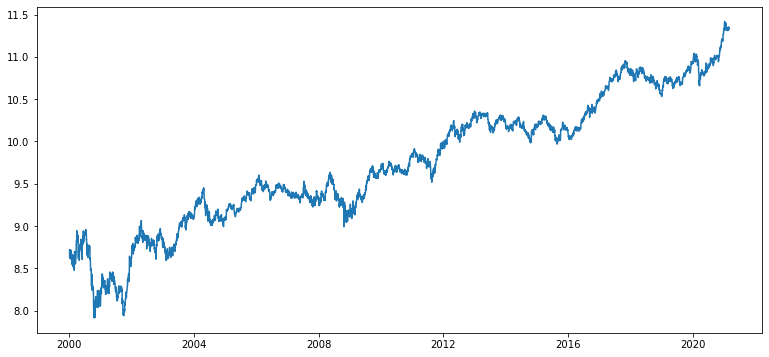


정성적 그래프 분석 :


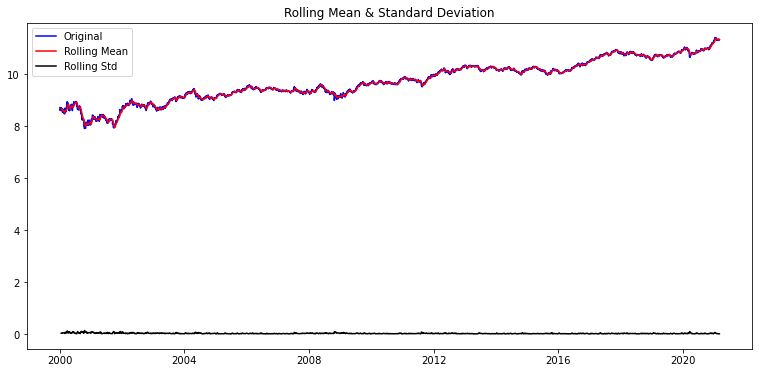


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64

시계열 분해 (Time Series Decomposition) :


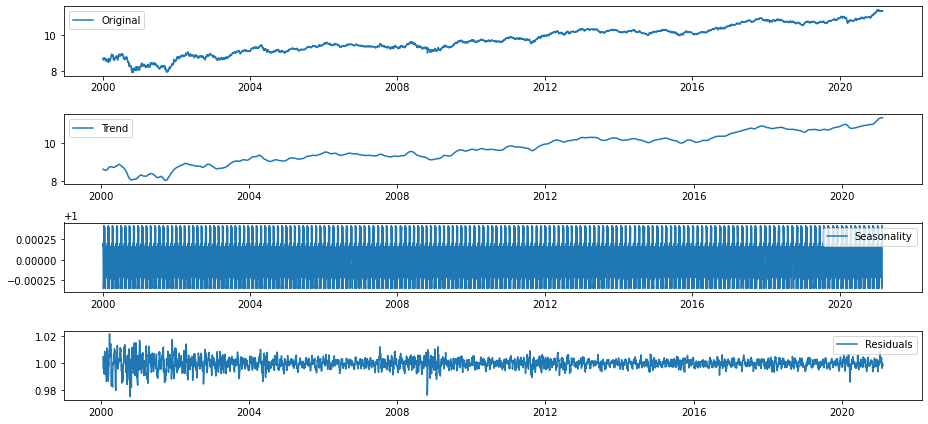

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64

학습과 테스트 데이터셋 :


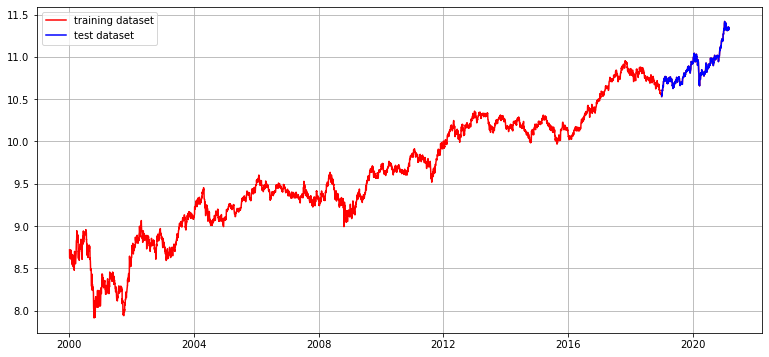


ACF : Autocorrelation 그래프 :


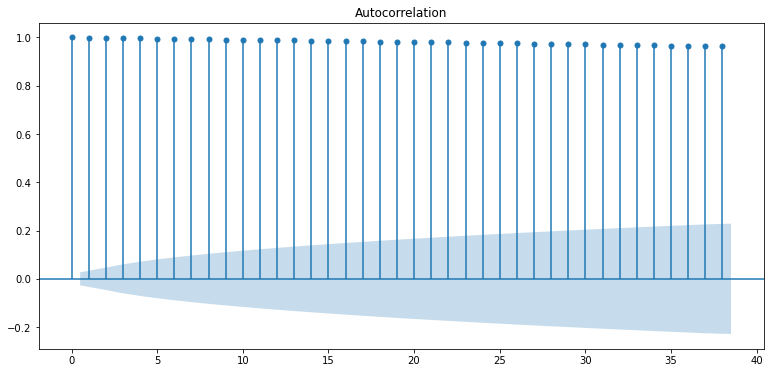


PACF : Partial Autocorrelation 그래프 :


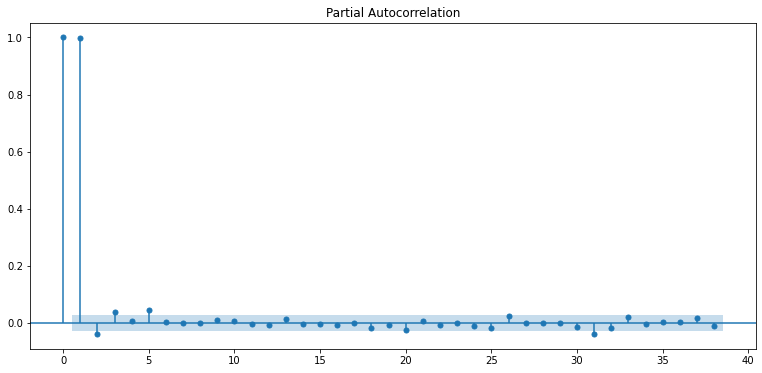


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -21.841431
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


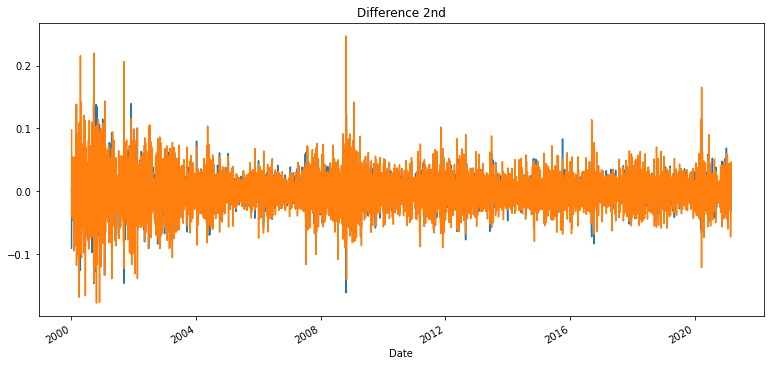

In [25]:
# 정성적 및 정량적 분석
stock_id = '005930.KS.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.
* 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.
* ACF 그래프는 점차적으로 감소하고 PACF는 1(p)차 이후 거의 0에 가까워지고 있다.
* 1차 차분에서 p-value는 거의 0이다.
* 따라서 p=1, d=1, q=0 으로 설정

In [26]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22551.378, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22558.473, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22559.791, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22552.068, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22557.535, Time=1.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-22582.162, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22599.253, Time=1.82 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22596.595, Time=2.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22597.324, Time=2.63 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22590.118, Time=1.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22598.058, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-22595.199, Time=2.47 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-22599.285, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-22582.741, Time=1.00 sec
 ARIM

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 2)   Log Likelihood               11304.629
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22599.258
Time:                        20:30:27   BIC                         -22566.890
Sample:                             1   HQIC                        -22587.889
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.381      0.167      -0.000       0.001
ar.L1.D.Close     0.6122      0.082      7.467      0.000       0.451       0.773
ma.L1.D.Close    -

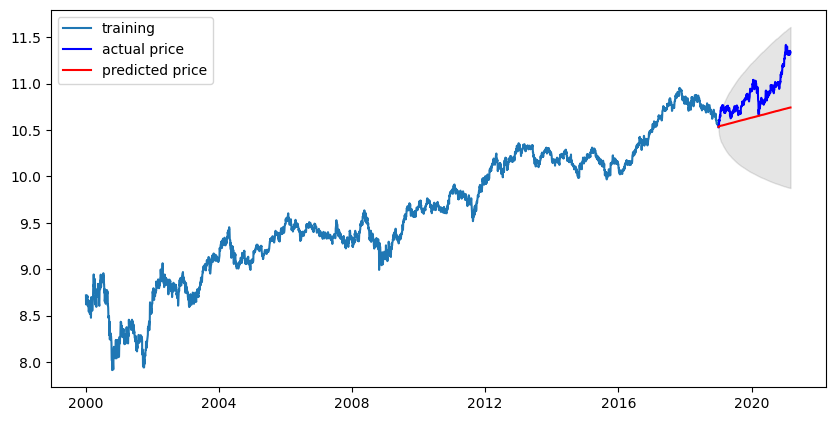


모델의 오차율 계산 :

MSE:  247258370.3825568
MAE:  12524.352843011759
RMSE:  15724.451353944174
MAPE: 20.89%


In [27]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 2
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 1, 1, 0  --> MAPE: 21.45%
* p, d, q = 1, 1, 1  --> MAPE: 21.42%
* p, d, q = 1, 1, 2  --> MAPE: 20.89%
* p, d, q = 1, 1, 3  --> The computed initial AR coefficients are not stationary
* p, d, q = 2, 1, 0  --> MAPE: 21.25%
* p, d, q = 2, 1, 1  --> MAPE: 20.93%

### 페이스북

로그 변환된 그래프 :


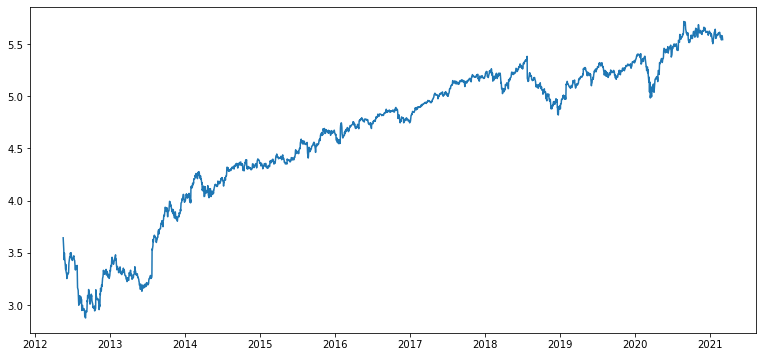


정성적 그래프 분석 :


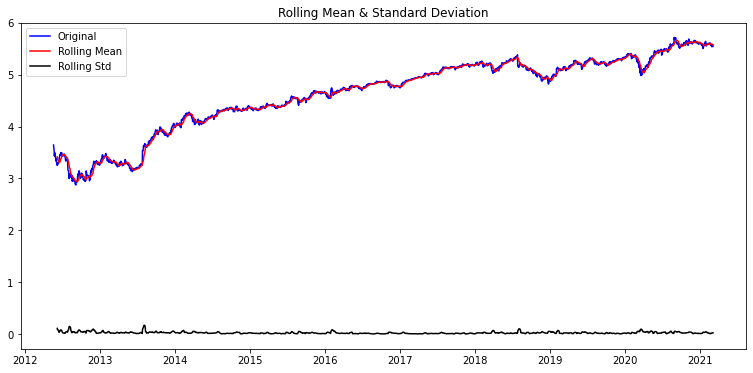


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -1.375919
p-value                           0.593765
#Lags Used                       10.000000
Number of Observations Used    2200.000000
Critical Value (1%)              -3.433326
Critical Value (5%)              -2.862855
Critical Value (10%)             -2.567470
dtype: float64

시계열 분해 (Time Series Decomposition) :


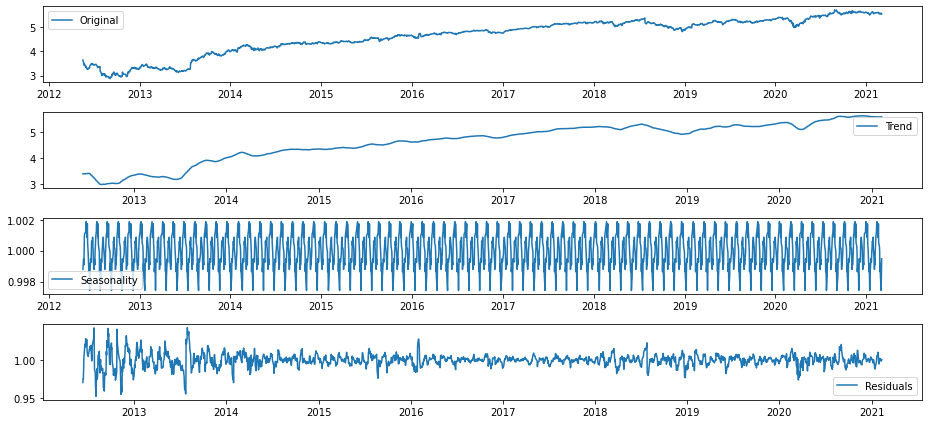

Results of Dickey-Fuller Test:
Test Statistic                -1.227692e+01
p-value                        8.391702e-23
#Lags Used                     2.600000e+01
Number of Observations Used    2.154000e+03
Critical Value (1%)           -3.433390e+00
Critical Value (5%)           -2.862883e+00
Critical Value (10%)          -2.567485e+00
dtype: float64

학습과 테스트 데이터셋 :


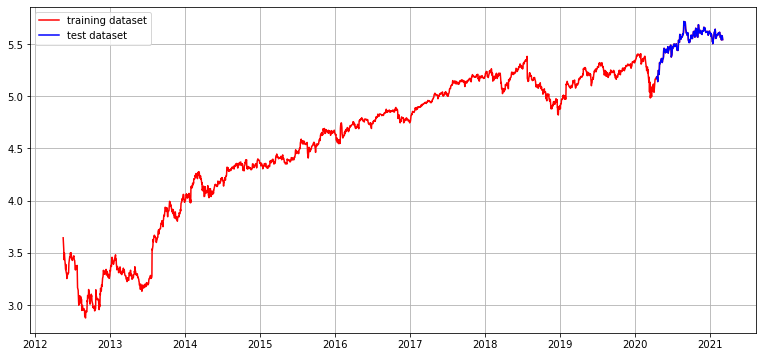


ACF : Autocorrelation 그래프 :


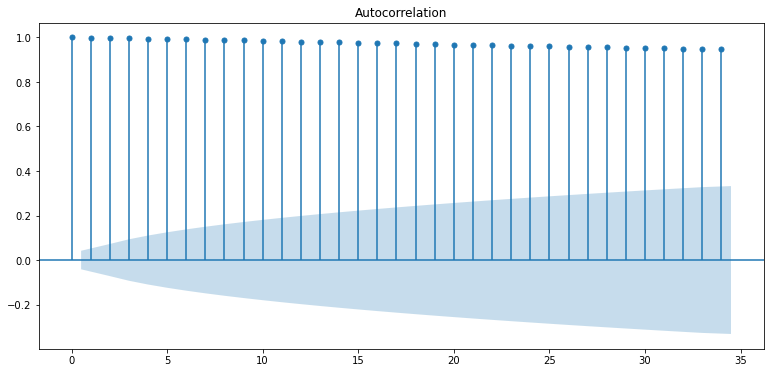


PACF : Partial Autocorrelation 그래프 :


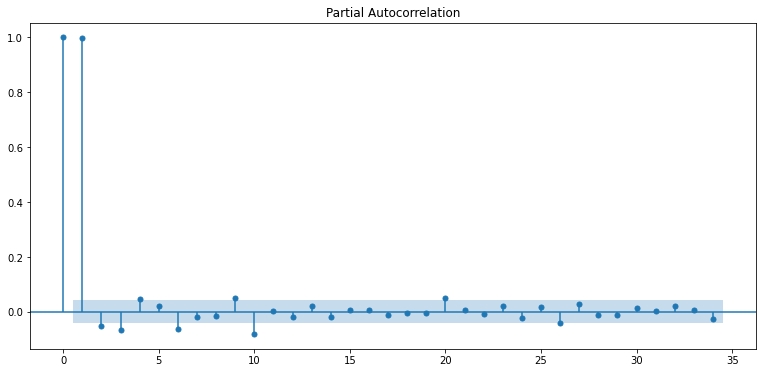


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.590967e+01
p-value                        8.150834e-29
#Lags Used                     9.000000e+00
Number of Observations Used    2.200000e+03
Critical Value (1%)           -3.433326e+00
Critical Value (5%)           -2.862855e+00
Critical Value (10%)          -2.567470e+00
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.787121e+01
p-value                        3.027126e-30
#Lags Used                     2.100000e+01
Number of Observations Used    2.187000e+03
Critical Value (1%)           -3.433344e+00
Critical Value (5%)           -2.862862e+00
Critical Value (10%)          -2.567474e+00
dtype: float64


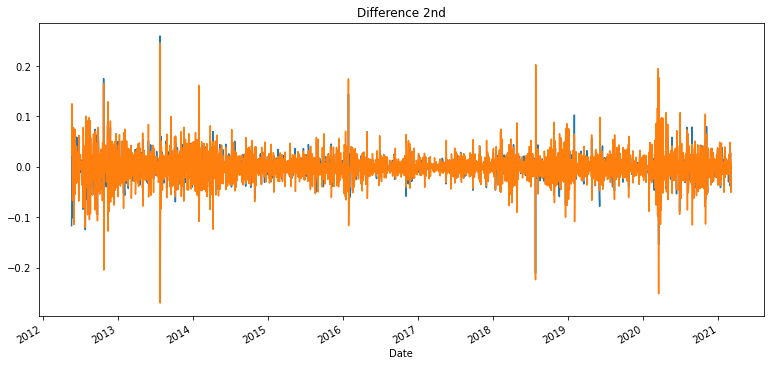

In [28]:
# 정성적 및 정량적 분석
stock_id = 'FB.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.
* 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.
* ACF 그래프는 점차적으로 감소하고 PACF는 1(p)차 이후 거의 0에 가까워지고 있다.
* 1차 차분에서 p-value는 거의 0이다.
* 따라서 p=1, d=1, q=0 으로 설정

In [29]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9308.464, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9308.079, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9308.022, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9308.281, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9306.140, Time=1.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.180 seconds


ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1988
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4656.232
Method:                           css   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                          -9308.464
Time:                        20:30:31   BIC                          -9297.274
Sample:                             1   HQIC                         -9304.354
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.478      0.139      -0.000       0.002

ARIMA 예측 :


/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

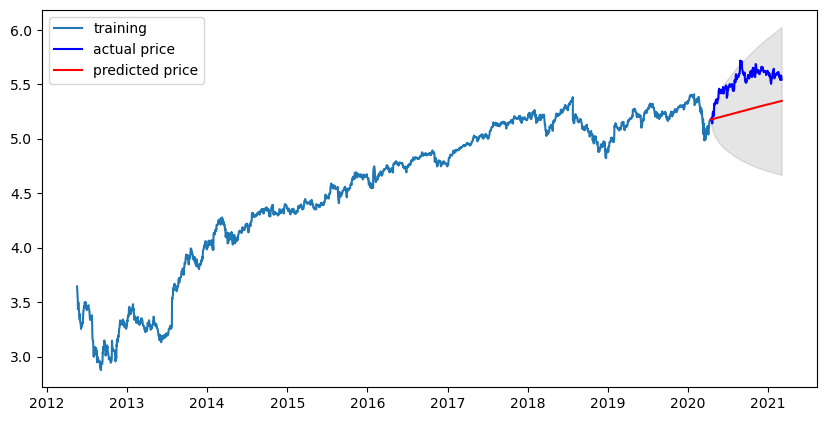


모델의 오차율 계산 :

MSE:  4129.7126732271245
MAE:  60.96418425660388
RMSE:  64.26284053189
MAPE: 23.40%


In [30]:
# ARIMA 모델의 오차율 계산
p, d, q = 0, 1, 0
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 1, 1, 0 --> MAPE: 23.37%
* p, d, q = 0, 1, 0 --> MAPE: 23.40%

### 현대자동차

로그 변환된 그래프 :


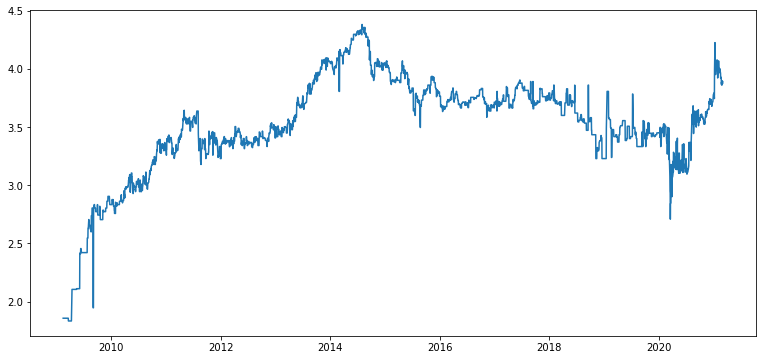


정성적 그래프 분석 :


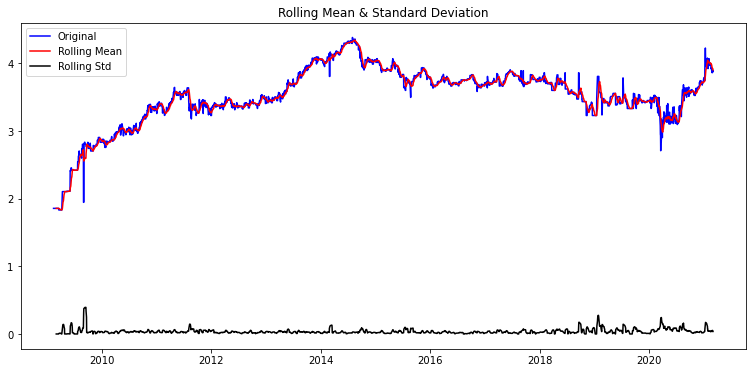


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -4.178299
p-value                           0.000717
#Lags Used                       25.000000
Number of Observations Used    3007.000000
Critical Value (1%)              -3.432527
Critical Value (5%)              -2.862502
Critical Value (10%)             -2.567282
dtype: float64

시계열 분해 (Time Series Decomposition) :


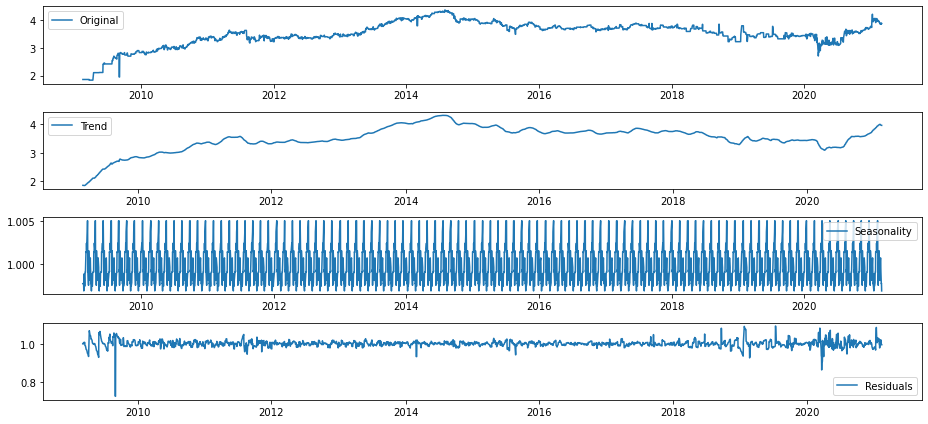

Results of Dickey-Fuller Test:
Test Statistic                -1.704997e+01
p-value                        8.083135e-30
#Lags Used                     2.900000e+01
Number of Observations Used    2.973000e+03
Critical Value (1%)           -3.432551e+00
Critical Value (5%)           -2.862513e+00
Critical Value (10%)          -2.567288e+00
dtype: float64

학습과 테스트 데이터셋 :


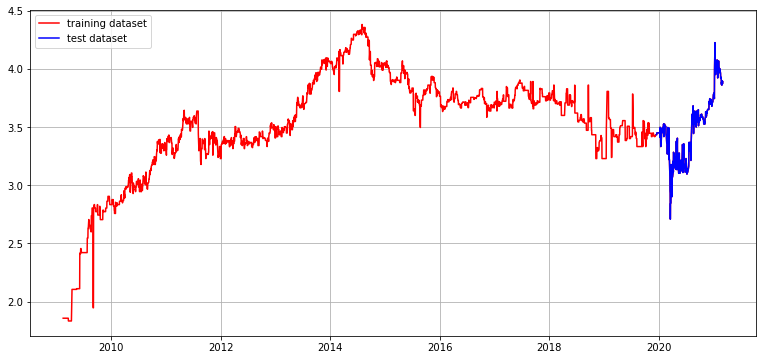


ACF : Autocorrelation 그래프 :


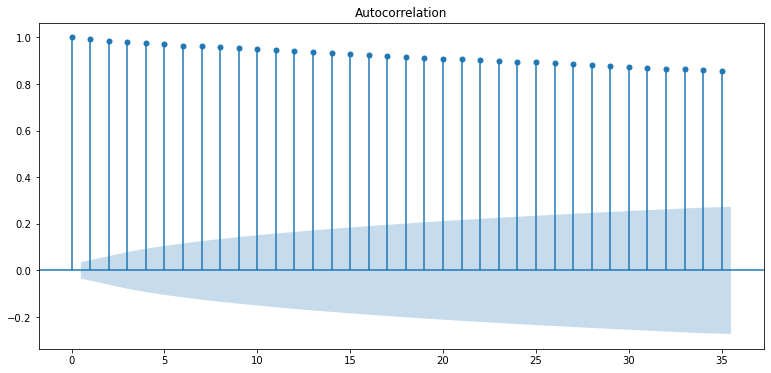


PACF : Partial Autocorrelation 그래프 :


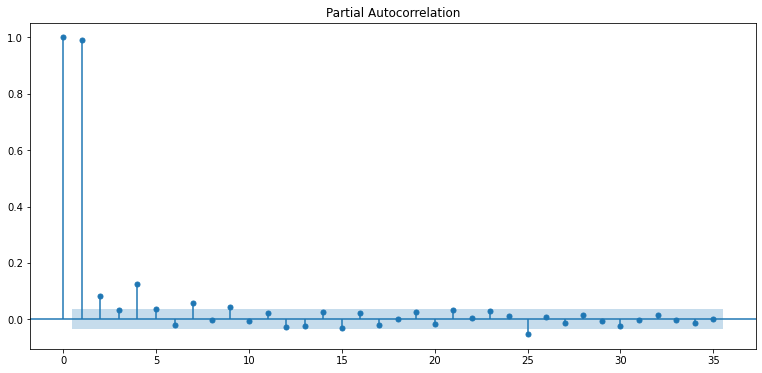


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.327523e+01
p-value                        7.890054e-25
#Lags Used                     2.400000e+01
Number of Observations Used    3.007000e+03
Critical Value (1%)           -3.432527e+00
Critical Value (5%)           -2.862502e+00
Critical Value (10%)          -2.567282e+00
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -19.304624
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    3002.000000
Critical Value (1%)              -3.432530
Critical Value (5%)              -2.862503
Critical Value (10%)             -2.567283
dtype: float64


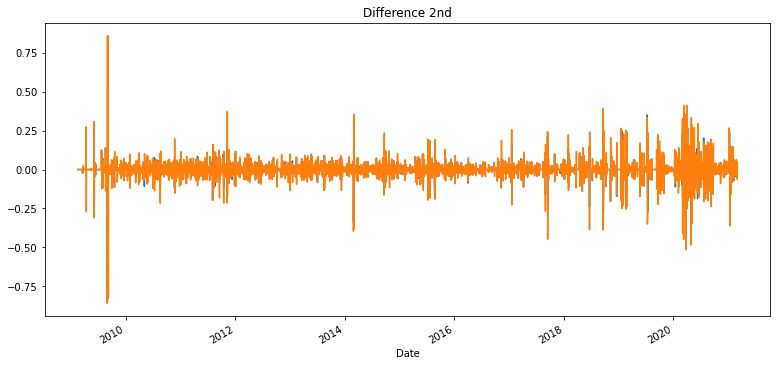

In [31]:
# 정성적 및 정량적 분석
stock_id = 'HYMTF.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

In [32]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9451.165, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9457.706, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9459.232, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9452.666, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9561.836, Time=1.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9569.871, Time=2.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9466.749, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9595.057, Time=2.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9591.679, Time=1.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-9591.210, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-9605.597, Time=2.80 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9558.088, Time=2.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-9599.255, Time=3.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9617.376, Time=3.07 sec
 ARIMA(2,1,3)(0,0,0

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2728
Model:                 ARIMA(1, 1, 4)   Log Likelihood                4818.077
Method:                       css-mle   S.D. of innovations              0.041
Date:                Thu, 04 Mar 2021   AIC                          -9622.155
Time:                        20:31:27   BIC                          -9580.776
Sample:                             1   HQIC                         -9607.199
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.580      0.114      -0.000       0.001
ar.L1.D.Close     0.8617      0.068     12.632      0.000       0.728       0.995
ma.L1.D.Close    -

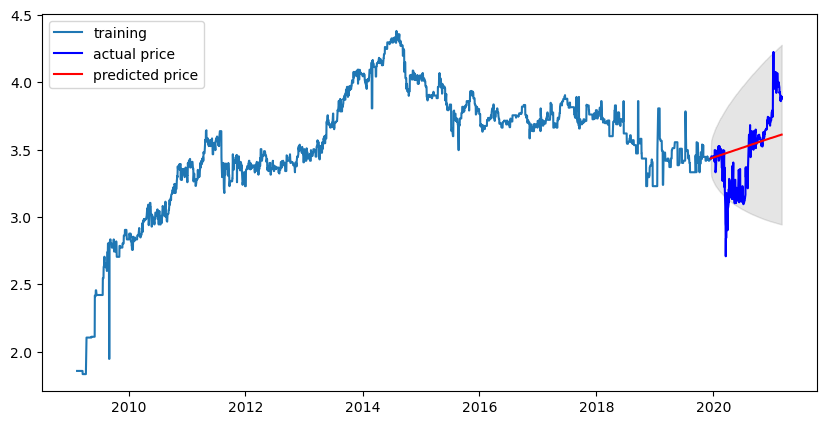


모델의 오차율 계산 :

MSE:  72.36988295972799
MAE:  6.306926743720915
RMSE:  8.507049015947187
MAPE: 20.35%


In [33]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 4
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 1, 1, 4 --> MAPE: 20.35%

### 엘지디스플레이

로그 변환된 그래프 :


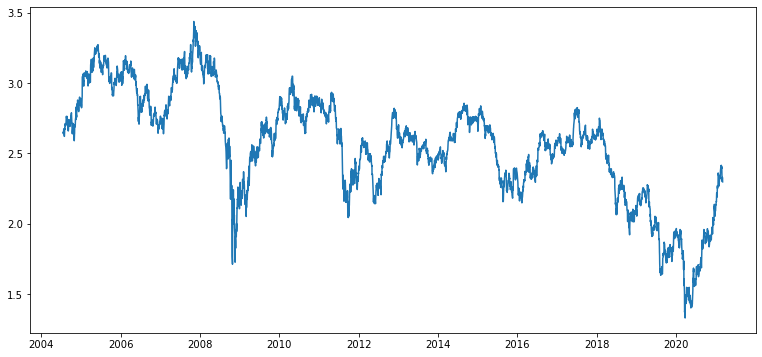


정성적 그래프 분석 :


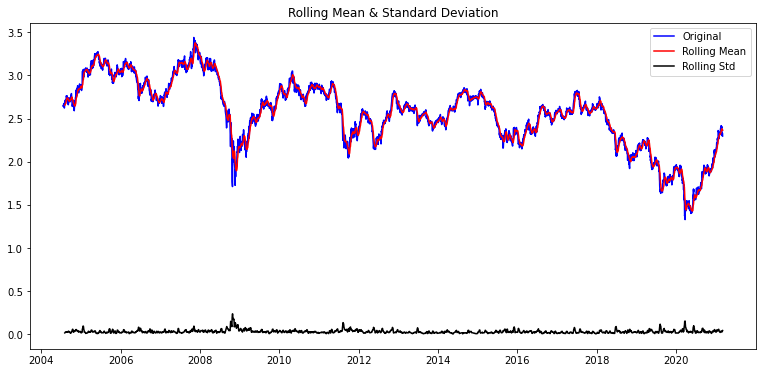


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -2.210624
p-value                           0.202412
#Lags Used                       21.000000
Number of Observations Used    4161.000000
Critical Value (1%)              -3.431923
Critical Value (5%)              -2.862235
Critical Value (10%)             -2.567140
dtype: float64

시계열 분해 (Time Series Decomposition) :


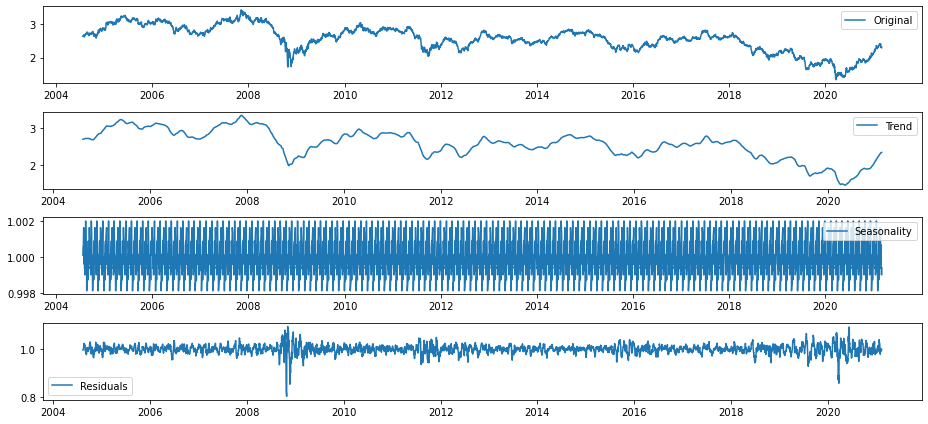

Results of Dickey-Fuller Test:
Test Statistic                -1.633057e+01
p-value                        3.063873e-29
#Lags Used                     3.100000e+01
Number of Observations Used    4.121000e+03
Critical Value (1%)           -3.431938e+00
Critical Value (5%)           -2.862242e+00
Critical Value (10%)          -2.567143e+00
dtype: float64

학습과 테스트 데이터셋 :


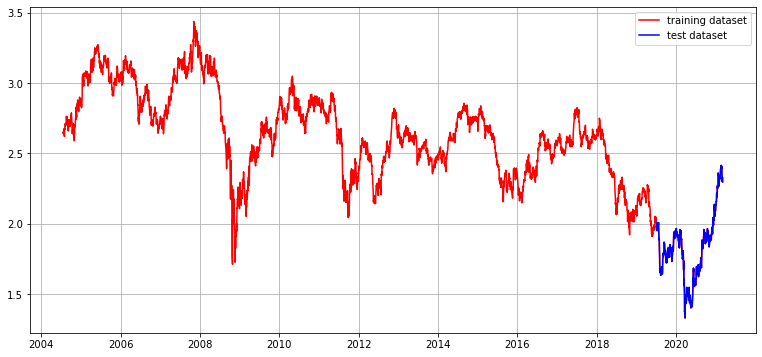


ACF : Autocorrelation 그래프 :


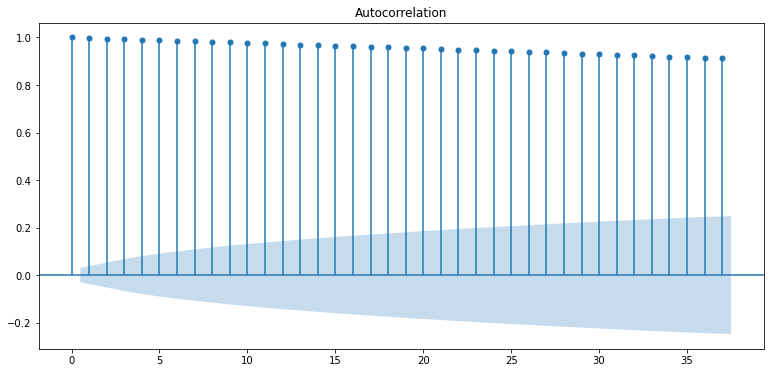


PACF : Partial Autocorrelation 그래프 :


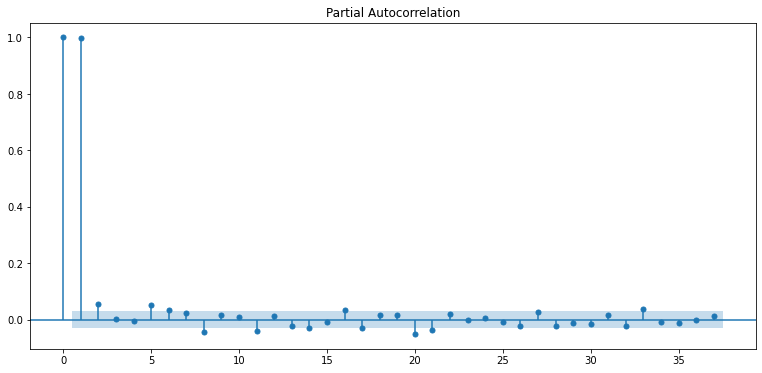


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.377840e+01
p-value                        9.395736e-26
#Lags Used                     2.000000e+01
Number of Observations Used    4.161000e+03
Critical Value (1%)           -3.431923e+00
Critical Value (5%)           -2.862235e+00
Critical Value (10%)          -2.567140e+00
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -19.251619
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4149.000000
Critical Value (1%)              -3.431927
Critical Value (5%)              -2.862237
Critical Value (10%)             -2.567141
dtype: float64


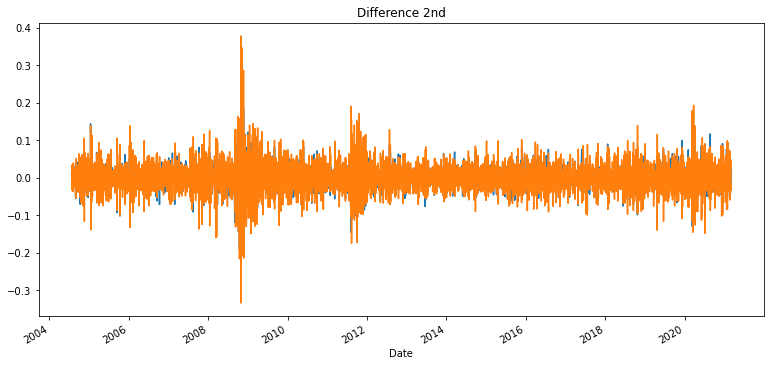

In [34]:
# 정성적 및 정량적 분석
stock_id = 'LPL.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

In [35]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16145.850, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16151.570, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16151.819, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16147.714, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16151.461, Time=1.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16150.759, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16153.955, Time=1.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16148.025, Time=0.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16151.961, Time=1.54 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16148.953, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16148.735, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16155.742, Time=3.75 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-16155.182, Time=2.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-16159.855, Time=3.04 sec
 ARIM

ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3763
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8078.785
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 04 Mar 2021   AIC                         -16151.571
Time:                        20:31:59   BIC                         -16132.872
Sample:                             1   HQIC                        -16144.922
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.385      0.700      -0.001       0.001
ar.L1.D.Close    -0.0453      0.016     -2.780      0.005      -0.077      -0.013
                  

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

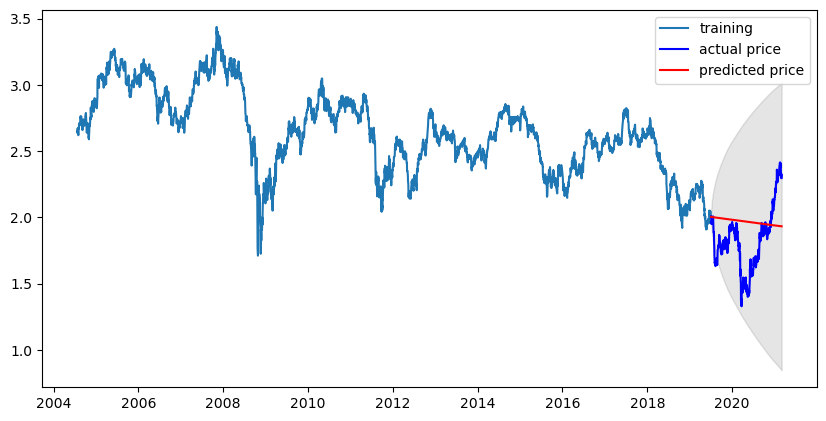


모델의 오차율 계산 :

MSE:  3.288362383981872
MAE:  1.4962299700832826
RMSE:  1.8133842350648888
MAPE: 25.80%


In [36]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 0
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 0, 1, 5 --> MAPE: 26.05%
* p, d, q = 1, 1, 0 --> MAPE: 25.80%

### SK 하이닉스

로그 변환된 그래프 :


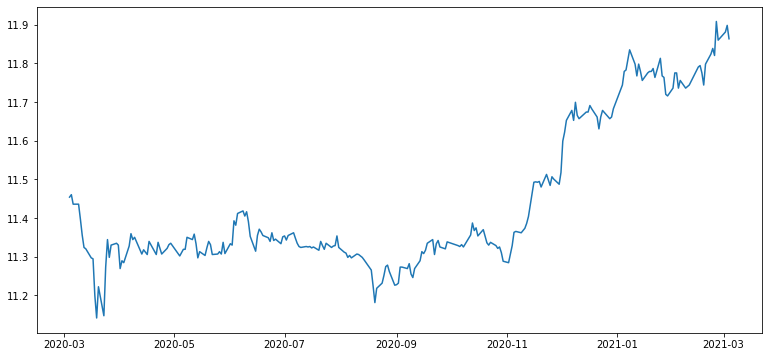


정성적 그래프 분석 :


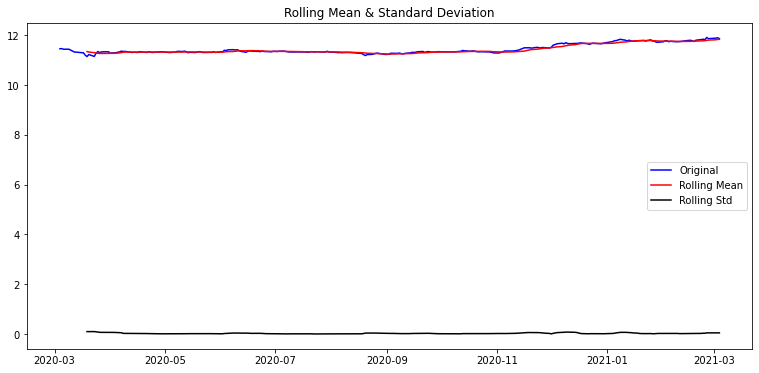


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                  -0.007251
p-value                          0.957928
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64

시계열 분해 (Time Series Decomposition) :


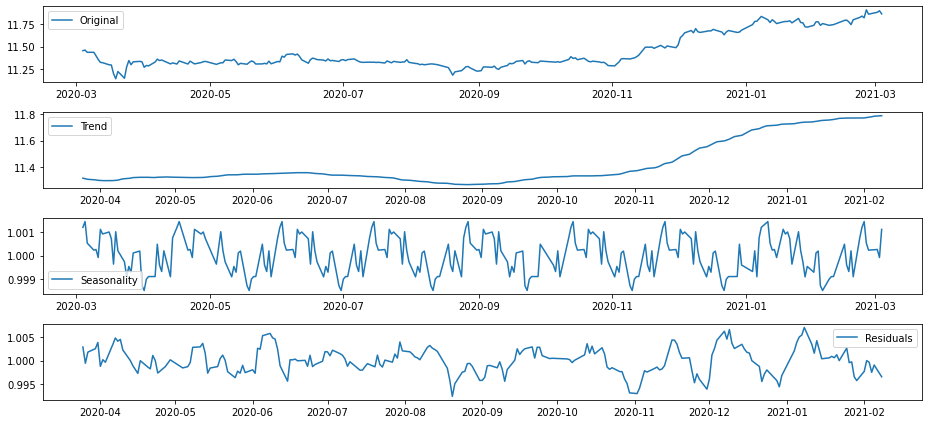

Results of Dickey-Fuller Test:
Test Statistic                -5.873431e+00
p-value                        3.200383e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64

학습과 테스트 데이터셋 :


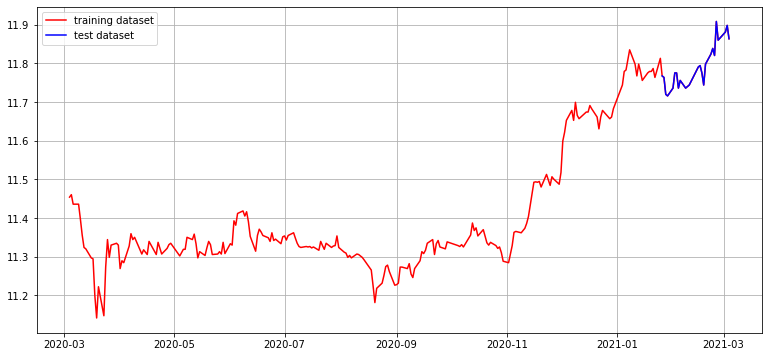


ACF : Autocorrelation 그래프 :


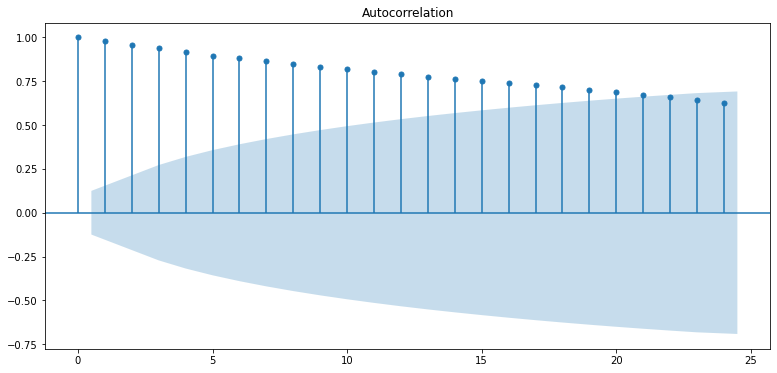


PACF : Partial Autocorrelation 그래프 :


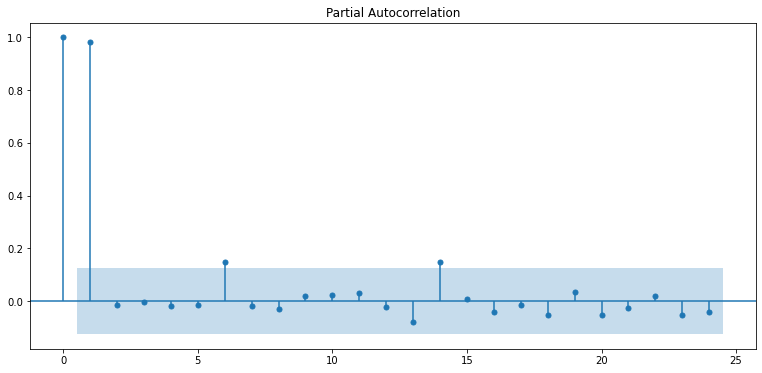


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.686778e+01
p-value                        1.087058e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -7.401934e+00
p-value                        7.515459e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


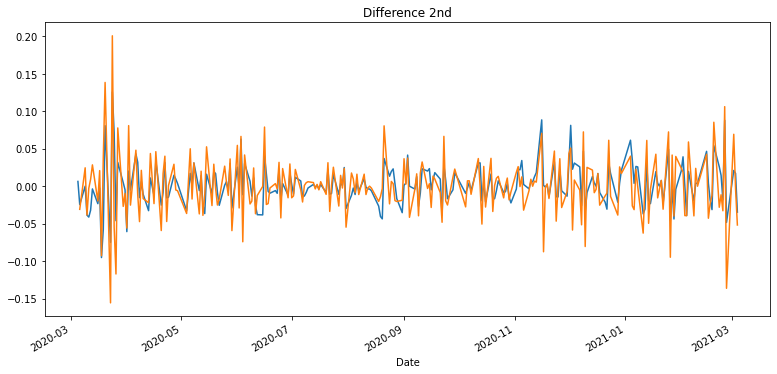

In [37]:
# 정성적 및 정량적 분석
stock_id = '000660.KS.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

In [38]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-972.126, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-970.475, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-970.460, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-973.303, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-968.415, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds


ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 488.238
Method:                       css-mle   S.D. of innovations              0.027
Date:                Thu, 04 Mar 2021   AIC                           -970.475
Time:                        20:32:01   BIC                           -960.281
Sample:                             1   HQIC                          -966.359
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.002      0.939      0.348      -0.002       0.005
ar.L1.D.Close    -0.0399      0.068     -0.591      0.554      -0.172       0.092
                  

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

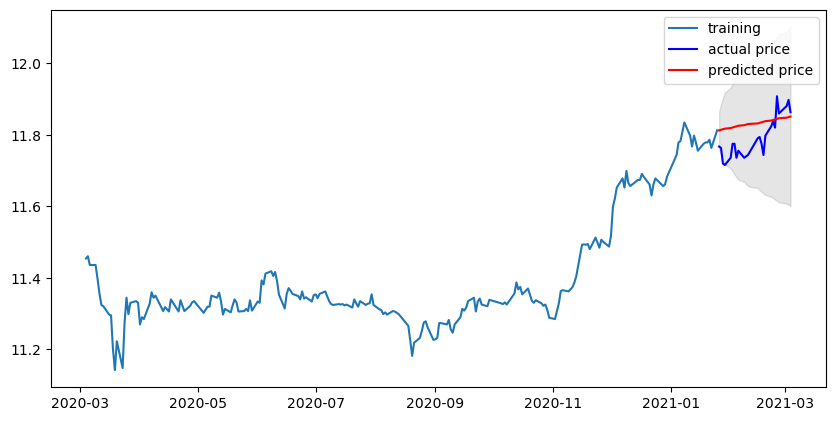


모델의 오차율 계산 :

MSE:  68248991.75778258
MAE:  7359.402388889424
RMSE:  8261.294799108828
MAPE: 5.69%


In [39]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 0
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 0, 1, 0 --> MAPE: 5.82%
* p, d, q = 1, 1, 0 --> MAPE: 5.69%

### 테슬라

로그 변환된 그래프 :


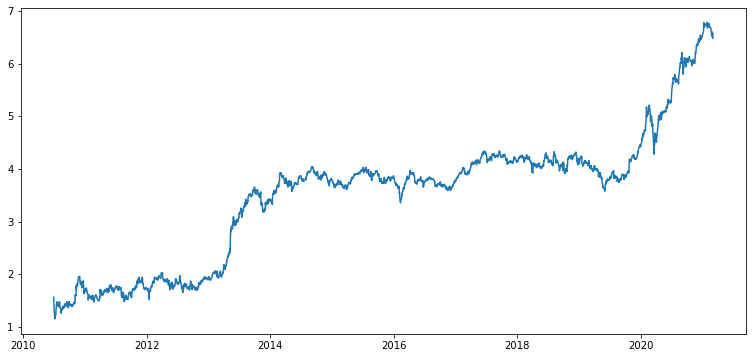


정성적 그래프 분석 :


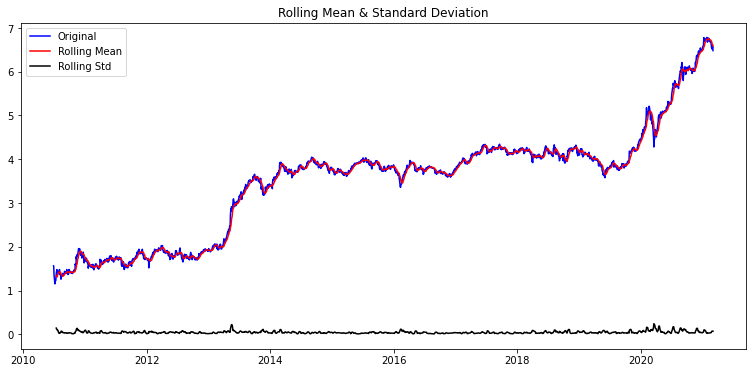


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                    0.394921
p-value                           0.981304
#Lags Used                        0.000000
Number of Observations Used    2687.000000
Critical Value (1%)              -3.432786
Critical Value (5%)              -2.862616
Critical Value (10%)             -2.567343
dtype: float64

시계열 분해 (Time Series Decomposition) :


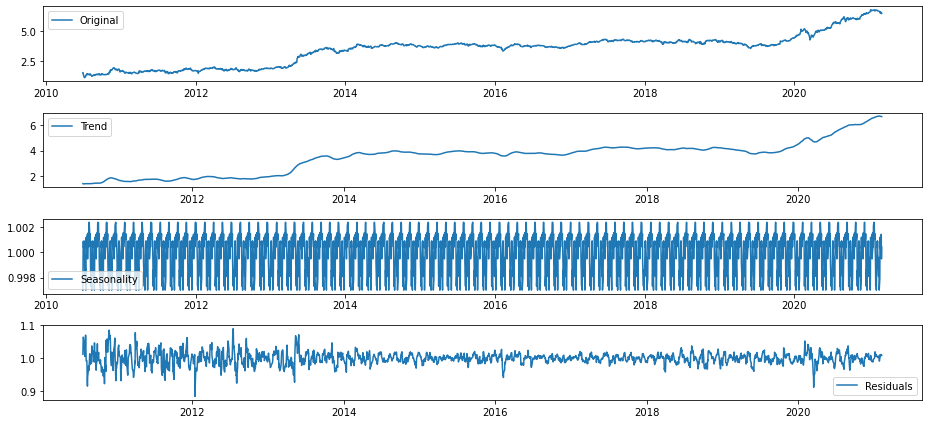

Results of Dickey-Fuller Test:
Test Statistic                -1.260241e+01
p-value                        1.724662e-23
#Lags Used                     2.800000e+01
Number of Observations Used    2.629000e+03
Critical Value (1%)           -3.432840e+00
Critical Value (5%)           -2.862640e+00
Critical Value (10%)          -2.567356e+00
dtype: float64

학습과 테스트 데이터셋 :


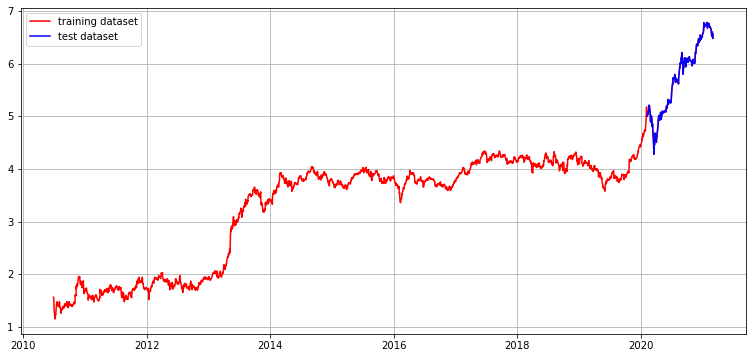


ACF : Autocorrelation 그래프 :


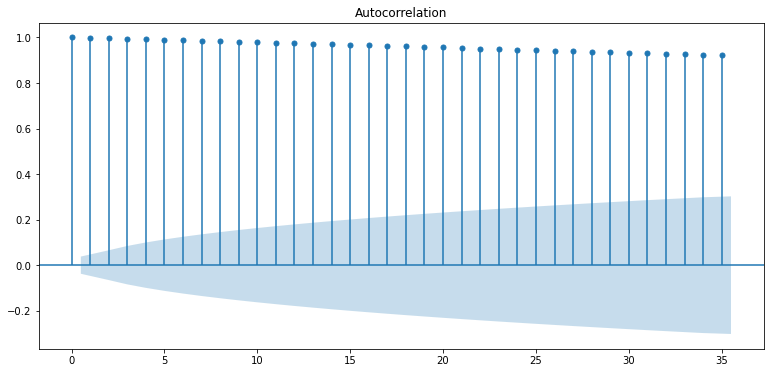


PACF : Partial Autocorrelation 그래프 :


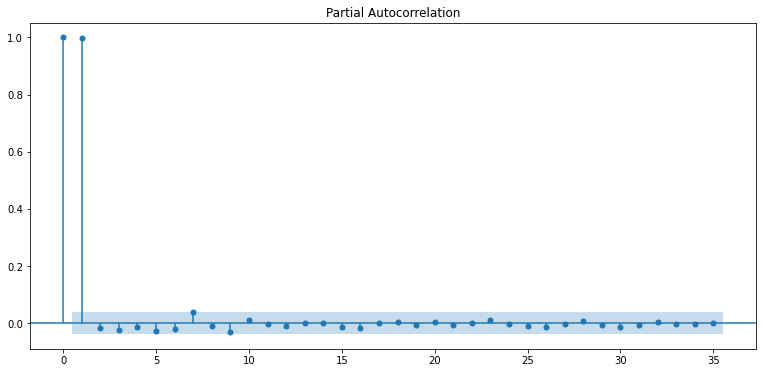


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -51.426539
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2686.000000
Critical Value (1%)              -3.432787
Critical Value (5%)              -2.862617
Critical Value (10%)             -2.567343
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.653953e+01
p-value                        1.989686e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.658000e+03
Critical Value (1%)           -3.432813e+00
Critical Value (5%)           -2.862628e+00
Critical Value (10%)          -2.567349e+00
dtype: float64


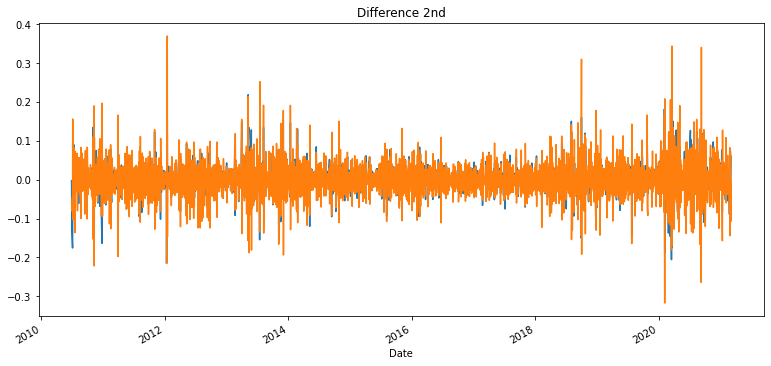

In [40]:
# 정성적 및 정량적 분석
stock_id = 'TSLA.csv'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

In [41]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9655.672, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9653.856, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9653.866, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9653.122, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9651.943, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.883 seconds


/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

ARIMA fitted model :

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2418
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4830.977
Method:                       css-mle   S.D. of innovations              0.033
Date:                Thu, 04 Mar 2021   AIC                          -9651.954
Time:                        20:32:05   BIC                          -9623.001
Sample:                             1   HQIC                         -9641.425
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      2.234      0.025       0.000       0.003
ar.L1.D.Close     0.4695      0.544      0.863      0.388      -0.596       1.535
ma.L1.D.Close    -

/home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


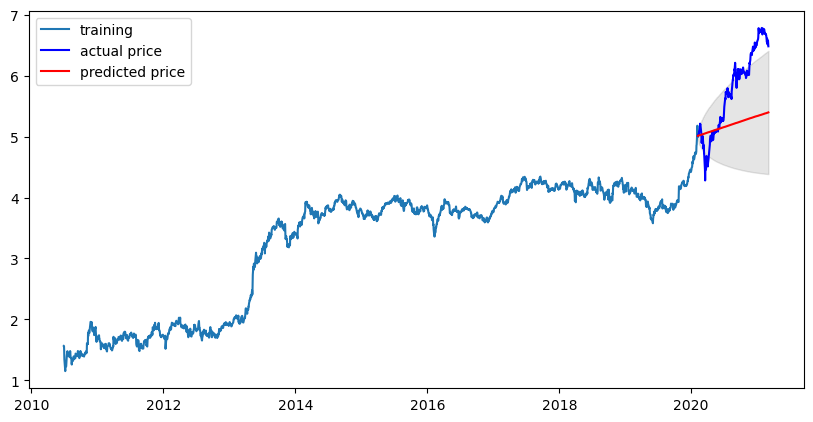


모델의 오차율 계산 :

MSE:  87264.54628346836
MAE:  213.88524893463975
RMSE:  295.4057316361149
MAPE: 43.93%


In [42]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 2
stock_metrics(train_data, test_data, p, d, q)

* p, d, q = 0, 1, 0 --> MAPE: 43.97%
* p, d, q = 1, 1, 0 --> MAPE: 43.97%

## 회고
* 시계열 데이터를 분석하려면 통계분석 프로그램(R)을 먼저 배워야겠다는 생각이 많이 들었다.
* ARIMA 모델에 들어가는 p, d, q 값을 설정하는 원리를 아직 이해하지 못하였다.
  - p, d, q 값을 자동으로 찾아 주는 auto_arima() 함수를 찾아서 사용해보았으나 잘 맞지 않았다.
  - 예측 값을 직선으로 하였기 때문이 아닐까 생각한다.
  - 또는 auto_arima() 함수에서 계절성을 생략하였기 때문일 수도 있겠다.